# Speech Emotion Recognition


#### Task Description：
Fine-tune Hubert model for Speech Emotion Recognition.


#### Solution:
This program will follow the steps:
1. General Preparation  
2. Data Processing 
3. Loading the Model and Optimizer  
4. Training 
5. Testing 

## 1. General Preparation

Import some common libraries.

In [1]:
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

Use GPU Facilities.

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda - Tesla T4


In [4]:
import os
import shutil

def organize_emotions(source_directory, target_directory):
    # Dictionary mapping from the letter in filename to emotion
    emotion_map = {
        'W': 'anger',
        'L': 'boredom',
        'E': 'disgust',
        'A': 'anxiety',
        'F': 'happiness',
        'T': 'sadness',
        'N': 'neutral'
    }
    
    # Create directories for each emotion if they don't exist
    for emotion in emotion_map.values():
        os.makedirs(os.path.join(target_directory, emotion), exist_ok=True)
    
    # Iterate through each file in the source directory
    for filename in os.listdir(source_directory):
        if filename.endswith('.wav'):  # Check if it's a WAV file
            if len(filename) > 5:  # Ensure the filename has the correct length
                emotion_code = filename[5]  # Extract the emotion letter from filename
                emotion_folder = emotion_map.get(emotion_code)
                
                if emotion_folder:  # Check if the emotion code is valid
                    # Path to the source file and target file
                    src_path = os.path.join(source_directory, filename)
                    dst_path = os.path.join(target_directory, emotion_folder, filename)
                    
                    # Copy the file to the appropriate emotion directory (instead of move)
                    shutil.copy(src_path, dst_path)
                    print(f'Copied {filename} to {emotion_folder}/')
                else:
                    print(f'Unknown emotion code "{emotion_code}" in file {filename}')
            else:
                print(f'Filename {filename} is too short to extract emotion code.')

# Usage example
source_dir = '/kaggle/input/berlin-database-of-emotional-speech-emodb/wav'  # Update this path
target_dir = '/kaggle/working/EMODB'  # Update this path
organize_emotions(source_dir, target_dir)


import os
import csv

def create_csv_from_emotion_folders(target_directory, output_csv):
    # List of emotions that are present in the target directory
    emotions = ['disgust', 'anger', 'happiness', 'boredom', 'neutral', 'anxiety', 'sadness']
    
    # Open the CSV file for writing
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(['Emotion', 'Path'])
        
        # Iterate through each emotion folder
        for emotion in emotions:
            emotion_folder = os.path.join(target_directory, emotion)
            
            # Check if the folder exists and iterate through its files
            if os.path.exists(emotion_folder):
                for filename in os.listdir(emotion_folder):
                    if filename.endswith('.wav'):  # Ensure it's a .wav file
                        file_path = os.path.join(emotion_folder, filename)
                        writer.writerow([emotion, file_path])  # Write emotion and file path

# Usage example
target_dir = '/kaggle/working/EMODB'  # The directory where the emotion folders are located
output_csv = '/kaggle/working/Emodb.csv'  # Path to the output CSV file
create_csv_from_emotion_folders(target_dir, output_csv)


Copied 15a04Fd.wav to happiness/
Copied 13b02Fb.wav to happiness/
Copied 09b01Wb.wav to anger/
Copied 15a01Wa.wav to anger/
Copied 14a05Wa.wav to anger/
Copied 03a05Aa.wav to anxiety/
Copied 11a04Wc.wav to anger/
Copied 09a05Tb.wav to sadness/
Copied 12a01Wc.wav to anger/
Copied 12a04Wc.wav to anger/
Copied 09a04La.wav to boredom/
Copied 08b02Nb.wav to neutral/
Copied 12b10Wa.wav to anger/
Copied 15a07Ld.wav to boredom/
Copied 10a07La.wav to boredom/
Copied 11a05Fb.wav to happiness/
Copied 03b01Nb.wav to neutral/
Copied 12b02Ea.wav to disgust/
Copied 08a01Ab.wav to anxiety/
Copied 10a01Ac.wav to anxiety/
Copied 12a02Wa.wav to anger/
Copied 14a02Fd.wav to happiness/
Copied 09a04Wa.wav to anger/
Copied 03b01Wa.wav to anger/
Copied 15a04Nc.wav to neutral/
Copied 09a05Lc.wav to boredom/
Copied 14a01Ea.wav to disgust/
Copied 09a02La.wav to boredom/
Copied 15b03Nb.wav to neutral/
Copied 14b02Wb.wav to anger/
Copied 12a07Ac.wav to anxiety/
Copied 11b01Wd.wav to anger/
Copied 08a07Wc.wav to an

In this demonstration, I am only choosing 4 emotions, neutral, happy, sad and angry.

In [7]:
import pandas as pd
emodb = pd.read_csv("/kaggle/working/Emodb.csv")

emodb = emodb[(emodb["Emotion"] == "neutral") | 
              (emodb["Emotion"] == "happiness") | 
              (emodb["Emotion"] == "sadness") | 
              (emodb["Emotion"] == "anger")]


Split into training data and test data.

In [8]:
train_df = emodb.sample(frac=0.8)
test_df = emodb.drop(train_df.index)

Let's have a look at the training data.

### 2.2 Tokenization

In [9]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["Path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Map:   0%|          | 0/271 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [12]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {
            'neutral': 0,
            'happiness': 1,
            'sadness': 2,
            'anger': 3,
        }
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, list(train_data["Emotion"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["Emotion"]))


## 3. Loading the Model and Optimizer 

In [13]:
#import torch.nn as nn
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
#model.classifier = nn.Linear(model.classifier.in_features, 6)
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at superb/hubert-large-superb-er were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametri

## 4. Training

Prepare some utility functions.

In [15]:
# Check unique labels in the training and test data
print(set(train_data["Emotion"]))
print(set(test_data["Emotion"]))

{'happiness', 'anger', 'sadness', 'neutral'}
{'happiness', 'anger', 'sadness', 'neutral'}


In [16]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

Train the model.

In [17]:
# Training

from torch.utils.data import DataLoader

# Set the number of epoch
epoch = 10

# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/10


100%|██████████| 136/136 [01:34<00:00,  1.44it/s, Loss=1.629, Accuracy=0.380]


Epoch 2/10


100%|██████████| 136/136 [01:36<00:00,  1.40it/s, Loss=2.816, Accuracy=0.672]


Epoch 3/10


100%|██████████| 136/136 [01:36<00:00,  1.41it/s, Loss=0.224, Accuracy=0.771]


Epoch 4/10


100%|██████████| 136/136 [01:36<00:00,  1.41it/s, Loss=0.327, Accuracy=0.779]


Epoch 5/10


100%|██████████| 136/136 [01:36<00:00,  1.41it/s, Loss=0.030, Accuracy=0.863]


Epoch 6/10


100%|██████████| 136/136 [01:36<00:00,  1.40it/s, Loss=0.012, Accuracy=0.863]


Epoch 7/10


100%|██████████| 136/136 [01:36<00:00,  1.40it/s, Loss=0.747, Accuracy=0.915]


Epoch 8/10


100%|██████████| 136/136 [01:36<00:00,  1.41it/s, Loss=0.138, Accuracy=0.937]


Epoch 9/10


100%|██████████| 136/136 [01:36<00:00,  1.41it/s, Loss=0.000, Accuracy=0.930]


Epoch 10/10


100%|██████████| 136/136 [01:36<00:00,  1.41it/s, Loss=0.100, Accuracy=0.926]


In [16]:
torch.save(model.state_dict(), '/kaggle/working/model_final_epoch.pth')

In [18]:
print("input_ids shape:", input_ids.shape)
print("attention_mask shape:", attention_mask.shape)
print("labels shape:", labels.shape)

input_ids shape: torch.Size([1, 143652])
attention_mask shape: torch.Size([1, 143652])
labels shape: torch.Size([1])


Visualise the training loss and accuracy.

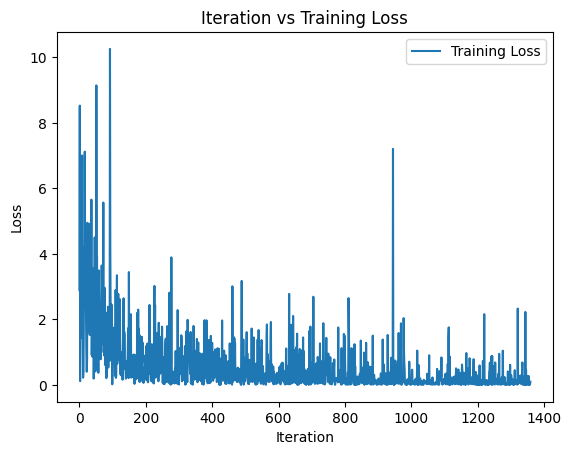

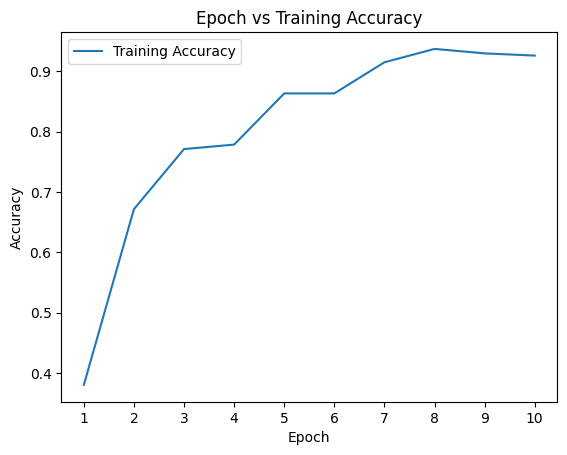

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

## 5. Testing

Test the model.

In [20]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 68/68 [00:06<00:00, 10.84it/s, loss=0.005, accuracy=0.853]


The final accuracy on the test dataset: 85.2941%


Check the result.

In [23]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]
    
df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

# Concat test texts and test records
df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
df["Emotions"] = df.apply(lambda x: x["Emotion"][:3], axis=1)

# Show test result
# pd.set_option('display.max_rows', None)    # Display all rows
# df

# Show incorrect predictions 
df[df["Emotion"]!=df["Model Prediction"]]

,index,Emotion,Path,Model Prediction,Emotions
0,49,anger,/kaggle/working/EMODB/anger/13b03Wc.wav,sad,ang
1,52,anger,/kaggle/working/EMODB/anger/03a07Wc.wav,sad,ang
2,54,anger,/kaggle/working/EMODB/anger/08a05Wa.wav,sad,ang
3,56,anger,/kaggle/working/EMODB/anger/03b02Wb.wav,ang,ang
4,66,anger,/kaggle/working/EMODB/anger/03a02Wc.wav,sad,ang
...,...,...,...,...,...
63,496,sadness,/kaggle/working/EMODB/sadness/16a07Td.wav,ang,sad
64,516,sadness,/kaggle/working/EMODB/sadness/13a05Tc.wav,ang,sad
65,523,sadness,/kaggle/working/EMODB/sadness/16a04Tc.wav,ang,sad
66,530,sadness,/kaggle/working/EMODB/sadness/10a05Tb.wav,ang,sad


Display the Confusion Matrix of the result.

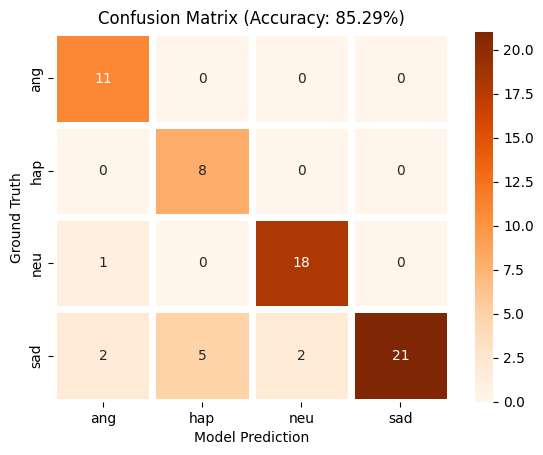

In [24]:
# Display the Confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()